In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words=[]
with open('names.txt', 'r') as file:
    words=file.read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s, i in stoi.items()}

In [5]:
block_size=3 #how many character to use to predict next one
def build_dataset(words):
    
    X,Y=[],[]
    for w in words:
        #print(w)
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])      #80%
Xdev,Ydev = build_dataset(words[n1:n2])  #10%
Xte,Yte = build_dataset(words[n2:])      #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd=20
n_hidden=180

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,n_embd), generator = g)

#multiplication fixes tanh values at the edges (grad=0) (problem with certain activation functions, can cause dead neurons)
W1=torch.randn((block_size*n_embd, n_hidden), generator = g) * (5/3) / (block_size*n_embd)**0.5
#b1=torch.randn(n_hidden, generator = g) * 0.01

#multiplication to make sure starting loss is low
W2=torch.randn((n_hidden,27), generator = g) * 0.01
b2=torch.randn(27, generator = g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters=[C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

16587


In [7]:
lre=torch.linspace(-3,0,1000)
lrs=10**lre

In [8]:
lri=[]
lossi=[]
stepi=[]

In [9]:
batch_size=62
max_steps=100000
for i in range(max_steps):
    #mini-batch
    ix=torch.randint(0,Xtr.shape[0],(batch_size,))
    
    #forward pass
    emb = C[Xtr[ix]]
    hpreact = emb.view(emb.shape[0],-1) @ W1 #+ b1
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    #Batch normalization
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    #counts = torch.exp(logits)
    #prob = counts / counts.sum(1, keepdims=True)
    #loss=-prob[torch.arange(32), Y].log().mean()
    loss=F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    #update
    #lr = lrs[i]
    lr=0.1
    if i>int(max_steps/3):
        lr=0.02
    if i>int(max_steps/3*2):
        lr=0.004
    for p in parameters:
        p.data += -lr * p.grad

    #track
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(f"{i}/{max_steps}: {loss.item()}")

print(loss.item())

0/100000: 3.286062479019165
10000/100000: 2.4315292835235596
20000/100000: 2.395148515701294
30000/100000: 1.9685449600219727
40000/100000: 2.1552724838256836
50000/100000: 2.025482654571533
60000/100000: 1.9735300540924072
70000/100000: 1.9541125297546387
80000/100000: 1.9342368841171265
90000/100000: 2.34253191947937
2.090059757232666


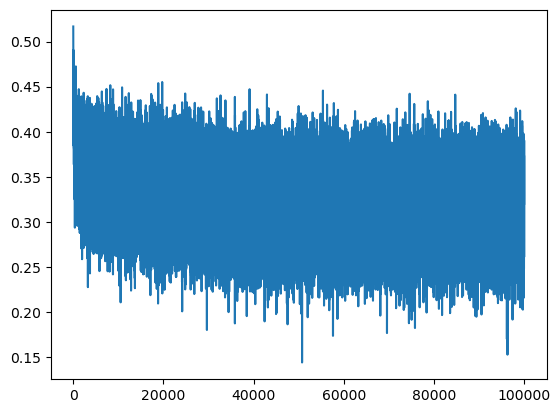

In [10]:
plt.plot(stepi,lossi)

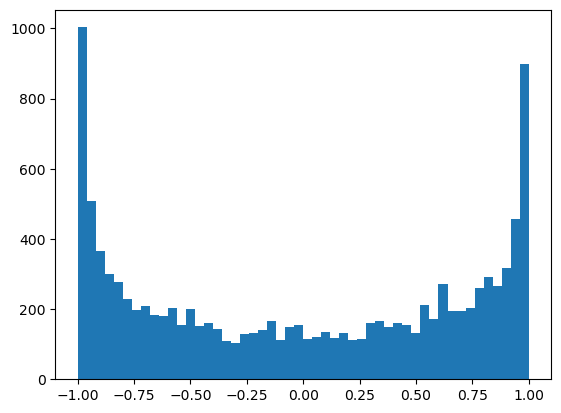

In [11]:
plt.hist(h.view(-1).tolist(),50);

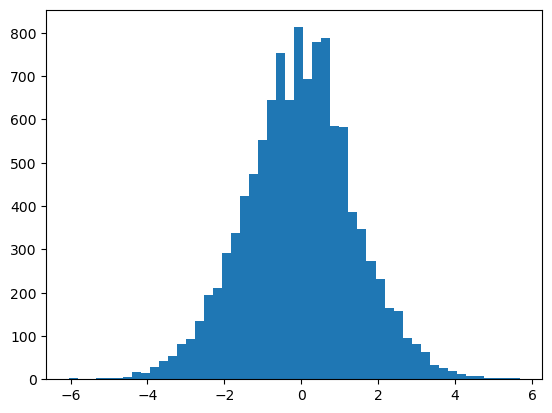

In [12]:
plt.hist(hpreact.view(-1).tolist(),50);

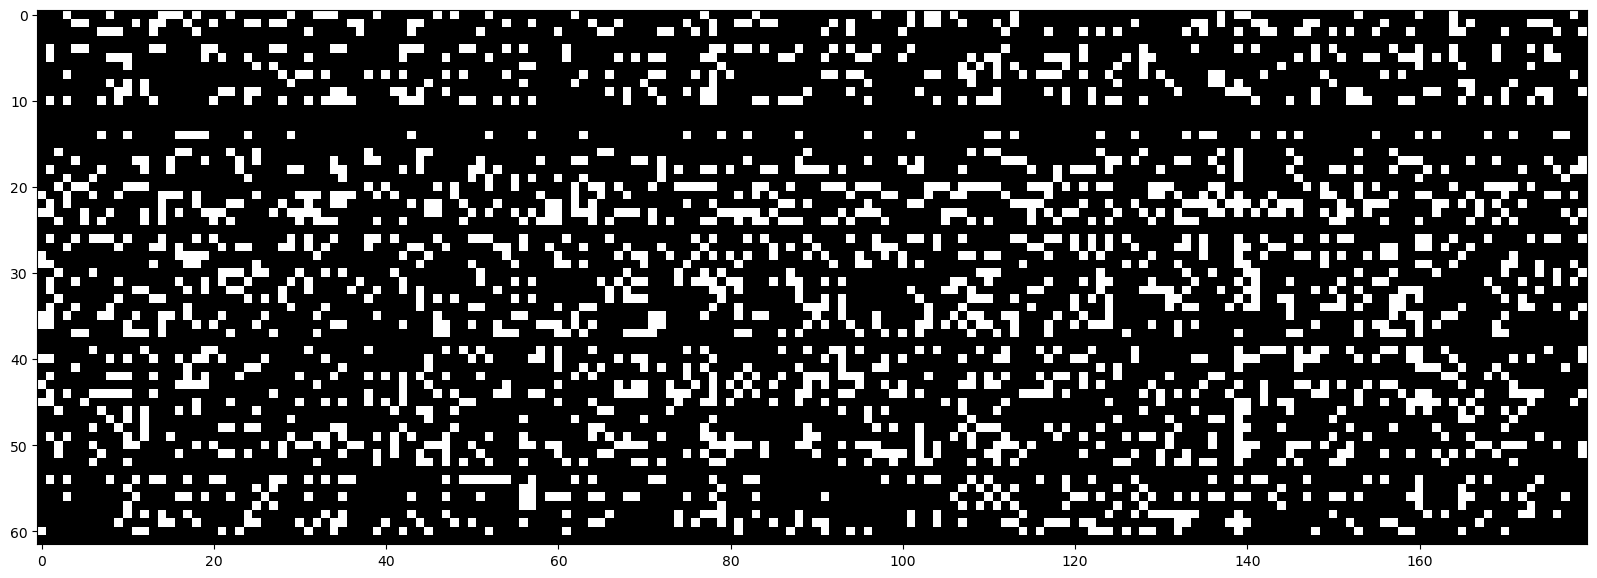

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.95, cmap='gray', interpolation='nearest')

In [ ]:
with torch.no_grad():
    emb = C[Xtr]
    hpreact = emb.view(emb.shape[0],-1) @ W1 #+ b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [ ]:
with torch.no_grad():
    emb= C[Xdev]
    hpreact = emb.view(emb.shape[0],-1) @ W1 #+ b1
    #Batch normalization
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    
    h=torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss=F.cross_entropy(logits, Ydev)
    print(loss.item())

In [22]:
for i in range(5):

    out=[]
    context =[0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        hpreact = emb.view(1,-1) @ W1 #+ b1
        #Batch normalization
        hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        #print(probs)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context=context[1:]+[ix]
        if ix == 0:
            break
        else:
            out.append(ix)

    print(''.join(itos[i] for i in out))

jessafvi
dokyabtuxa
blakelo
starraidy
gabriciah
